<a href="https://colab.research.google.com/github/jvishnuvardhan/Stackoverflow_Questions/blob/master/Functional_model_two_loss_with_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tf-nightly

In [3]:
import tensorflow as tf
tf.__version__

'2.2.0-dev20200424'

In [0]:
from tensorflow import keras
from tensorflow.keras import layers

In [0]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(shape=(None,), name='title')  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name='body')  # Variable-length sequence of ints
tags_input = keras.Input(shape=(num_tags,), name='tags')  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name='priority')(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name='department')(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(inputs=[title_input, body_input, tags_input],
                    outputs=[priority_pred, department_pred])

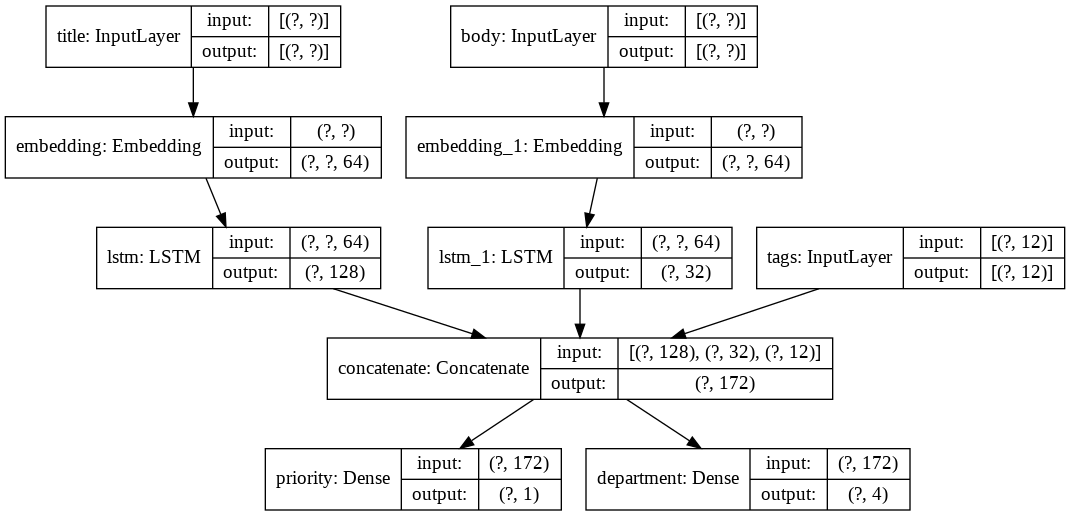

In [6]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [0]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss=[keras.losses.BinaryCrossentropy(from_logits=True),
                    keras.losses.CategoricalCrossentropy(from_logits=True)],
              loss_weights=[1., 0.2])

In [10]:
import numpy as np
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype('float32')

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit({'title': title_data, 'body': body_data, 'tags': tags_data},
          {'priority': priority_targets, 'department': dept_targets},
          epochs=2,
          batch_size=32)

Epoch 1/2
40/40 [==============================] - 2s 45ms/step - loss: 1.2723 - priority_loss: 0.7062 - department_loss: 2.8304
Epoch 2/2
40/40 [==============================] - 2s 46ms/step - loss: 1.2593 - priority_loss: 0.6995 - department_loss: 2.7993


In [11]:
# check how the weights and two loss are used to get overall loss
#(loss1*weight1+loss2*weight2)
(0.7062*1.0+2.8304*0.2)

1.27228